# Predicting Vehicle MPG

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.inspection import permutation_importance
import xlsxwriter


# Figures inline and set visualization style
%matplotlib inline
sns.set()

## Importing the data 

In [2]:
df_training = pd.read_excel("data.xlsx", sheet_name="1. Training Set of 1500 Cars")
target = df_training.mpg

df_testing = pd.read_excel("C://Users//Matthew//PycharmProjects//isds7103_project//df_testing_cleaned.xlsx")

df_predictions = pd.read_excel("C://Users//Matthew//PycharmProjects//isds7103_project//df_testing_cleaned.xlsx")


We see that the training set is clean, but the testing set needs some fixing.

Also, any binary variables for both sets will be recoded to be 0 or 1, instead of the default.

In [3]:
df_testing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  300 non-null    int64  
 1   id          300 non-null    int64  
 2   origin      300 non-null    object 
 3   maker       300 non-null    object 
 4   model       300 non-null    object 
 5   yr          300 non-null    int64  
 6   cyl         300 non-null    int64  
 7   2wh         300 non-null    int64  
 8   auto        300 non-null    int64  
 9   p/s         300 non-null    int64  
 10  a/c         300 non-null    int64  
 11  fro         300 non-null    int64  
 12  wght        300 non-null    int64  
 13  disp        300 non-null    float64
 14  hp          300 non-null    int64  
 15  lngth       300 non-null    float64
 16  wdth        300 non-null    float64
 17  wb          300 non-null    float64
 18  reli        300 non-null    int64  
 19  dom         300 non-null    i

In [4]:
df_training.head()

,id,origin,maker,model,yr,cyl,2wh,auto,p/s,a/c,...,wdth,wb,reli,fid,dom,eur,sales,price,markup,mpg
0,1,Japan,Toyota,TY-CELI,75,4,2,0,0,X,...,64.0,95.3,5,1,no,N,64922,3694,2.2030,18
1,2,Japan,Toyota,TY-CORO,75,4,4,0,0,X,...,62.0,93.3,5,1,no,N,151177,3089,1.7734,21
2,3,Japan,Datsun,DT-HLB2,75,4,4,0,0,X,...,61.0,92.1,5,2,no,N,140039,3089,1.7593,27
3,4,Japan,Datsun,DT-JHL7,75,4,4,0,0,X,...,63.0,96.5,5,2,no,N,50914,3639,2.1476,22
4,5,Japan,Datsun,DT-HL61,75,4,4,0,0,X,...,63.0,98.4,4,2,no,N,18527,4079,2.4706,22


In [5]:
def ac():
    ac_list = []
    for i in df_training["a/c"]:
        if i == "X":
            ac_list.append(0)
        elif i == "O":
            ac_list.append(1)

    return ac_list

df_training["a/c"] = ac()        

Now that A/C column is recoded to 0s and 1s, let's do the same for the columns, dom (domestic), eur (european). 

In [6]:
def dom():
    dom_list = []
    for i in df_training["dom"]:
        if i == "yes":
            dom_list.append(1)
        elif i == "no":
            dom_list.append(0)

    return dom_list

df_training["dom"] = dom()

In [7]:
def eur():
    eur_list = []
    for i in df_training["eur"]:
        if i == "Y":
            eur_list.append(1)
        elif i == "N":
            eur_list.append(0)

    return eur_list

df_training["eur"] = eur()


Now all recodings are done for the training set

## Dummy Variables for the Training Set

For the origin of the car manufacturer, we can recode this such that they are dummy variables. Using the get_dummies() method from pandas, four dummy variables are created (though we technically only need n-1 dummies). From the results in the cell below, we see that there are 866 American cars, 351 European, 276 Japanese, and 7 Korean. However, since there are no Korean cars in the testing set, let's recode Korean and Japanese cars as Asian.

In [8]:
pd.get_dummies(df_training["origin"]).value_counts()


Europe  Japan  Korean  U.S.
0       0      0       1       866
1       0      0       0       351
0       1      0       0       276
        0      1       0         7
dtype: int64

Here we change the name of the values in the origin column from Japan to Asian, then put Korean cars in same category as Japanese for the training set. Keep in mind that the testing set does not have any Korean cars.


In [9]:
df_training['origin'] = df_training['origin'].replace({'Japan':'Asian'})
df_training['origin'] = df_training['origin'].replace({'Korean':'Asian'})
df_training['origin'].value_counts()

U.S.      866
Europe    351
Asian     283
Name: origin, dtype: int64

In [10]:
pd.get_dummies(df_training["origin"]).value_counts()

Asian  Europe  U.S.
0      0       1       866
       1       0       351
1      0       0       283
dtype: int64

Next, we insert the dummy variables into the data frame (4 are created, though, since we used the drop_first = False argument).

In [11]:
def dummy_var_origin(df_training):

    df_training = pd.get_dummies(df_training, columns=['origin'], drop_first=False)
    return df_training   

df_training = dummy_var_origin(df_training)
df_training.head()

,id,maker,model,yr,cyl,2wh,auto,p/s,a/c,fro,...,fid,dom,eur,sales,price,markup,mpg,origin_Asian,origin_Europe,origin_U.S.
0,1,Toyota,TY-CELI,75,4,2,0,0,0,0,...,1,0,0,64922,3694,2.2030,18,1,0,0
1,2,Toyota,TY-CORO,75,4,4,0,0,0,0,...,1,0,0,151177,3089,1.7734,21,1,0,0
2,3,Datsun,DT-HLB2,75,4,4,0,0,0,0,...,2,0,0,140039,3089,1.7593,27,1,0,0
3,4,Datsun,DT-JHL7,75,4,4,0,0,0,0,...,2,0,0,50914,3639,2.1476,22,1,0,0
4,5,Datsun,DT-HL61,75,4,4,0,0,0,0,...,2,0,0,18527,4079,2.4706,22,1,0,0


Should we do the same process for the make of the car, or are there too many? For now, let's not consider the make or model of the car as features.

## Adding dummy variables into the testing set

In [12]:
df_testing['origin'] = df_testing['origin'].replace({'Japan':'Asian'})
pd.get_dummies(df_testing["origin"]).value_counts()



Asia  Europe  US
0     0       1     187
      1       0      57
1     0       0      56
dtype: int64

In [13]:
def dummy_var_origin2(df_testing):
    df_testing = pd.get_dummies(df_testing, columns=['origin'], drop_first=False)
    return df_testing   

df_testing = dummy_var_origin2(df_testing)
df_testing.head()

,Unnamed: 0,id,maker,model,yr,cyl,2wh,auto,p/s,a/c,...,reli,dom,eur,sales,price,markup,mpg,origin_Asia,origin_Europe,origin_US
0,0,1501,Volkswagen,VW-RABB,75,4,5,0,0,0,...,2,0,1,98215,3470.0,2.1005,?,0,1,0
1,1,1502,Mercedes-Benz,MB-280,75,6,4,1,1,1,...,4,0,1,9218,12756.0,8.9180,?,0,1,0
2,2,1503,AMC,AM-GREM,75,6,2,0,0,0,...,3,1,0,66614,2798.0,1.4212,?,0,0,1
3,3,1504,AMC,AM-PACE,75,6,2,0,0,0,...,1,1,0,96769,3299.0,1.6917,?,0,0,1
4,4,1505,Chrysler,PL-DUST,75,6,2,0,0,0,...,2,1,0,62909,3243.0,1.7583,?,0,0,1


## Feature Selection

Here we are experimenting with the best features for the ML model.

In [14]:
features = ['yr','cyl','2wh','auto','p/s','a/c','fro','wght','disp','hp',
           'lngth','wdth','wb','reli','dom','eur','sales','price','markup',
            'origin_Europe','origin_Asian','origin_U.S.','mpg']
def select_features(df_training, features):
    df_training = df_training[features]
    return df_training

In [15]:
features2 = ['yr','cyl','2wh','auto','p/s','a/c','fro','wght','disp','hp',
           'lngth','wdth','wb','reli','dom','eur','sales','price','markup',
            'origin_Europe','origin_Asia','origin_US','mpg']
df_testing = df_testing[features2]

In [16]:
df_training = select_features(df_training, features)
df_training.head()

,yr,cyl,2wh,auto,p/s,a/c,fro,wght,disp,hp,...,reli,dom,eur,sales,price,markup,origin_Europe,origin_Asian,origin_U.S.,mpg
0,75,4,2,0,0,0,0,2469,133.6,96,...,5,0,0,64922,3694,2.2030,0,1,0,18
1,75,4,4,0,0,0,0,2219,96.9,75,...,5,0,0,151177,3089,1.7734,0,1,0,21
2,75,4,4,0,0,0,0,1985,85.3,80,...,5,0,0,140039,3089,1.7593,0,1,0,27
3,75,4,4,0,0,0,0,2399,108.0,93,...,5,0,0,50914,3639,2.1476,0,1,0,22
4,75,4,4,0,0,0,0,2472,119.1,97,...,4,0,0,18527,4079,2.4706,0,1,0,22


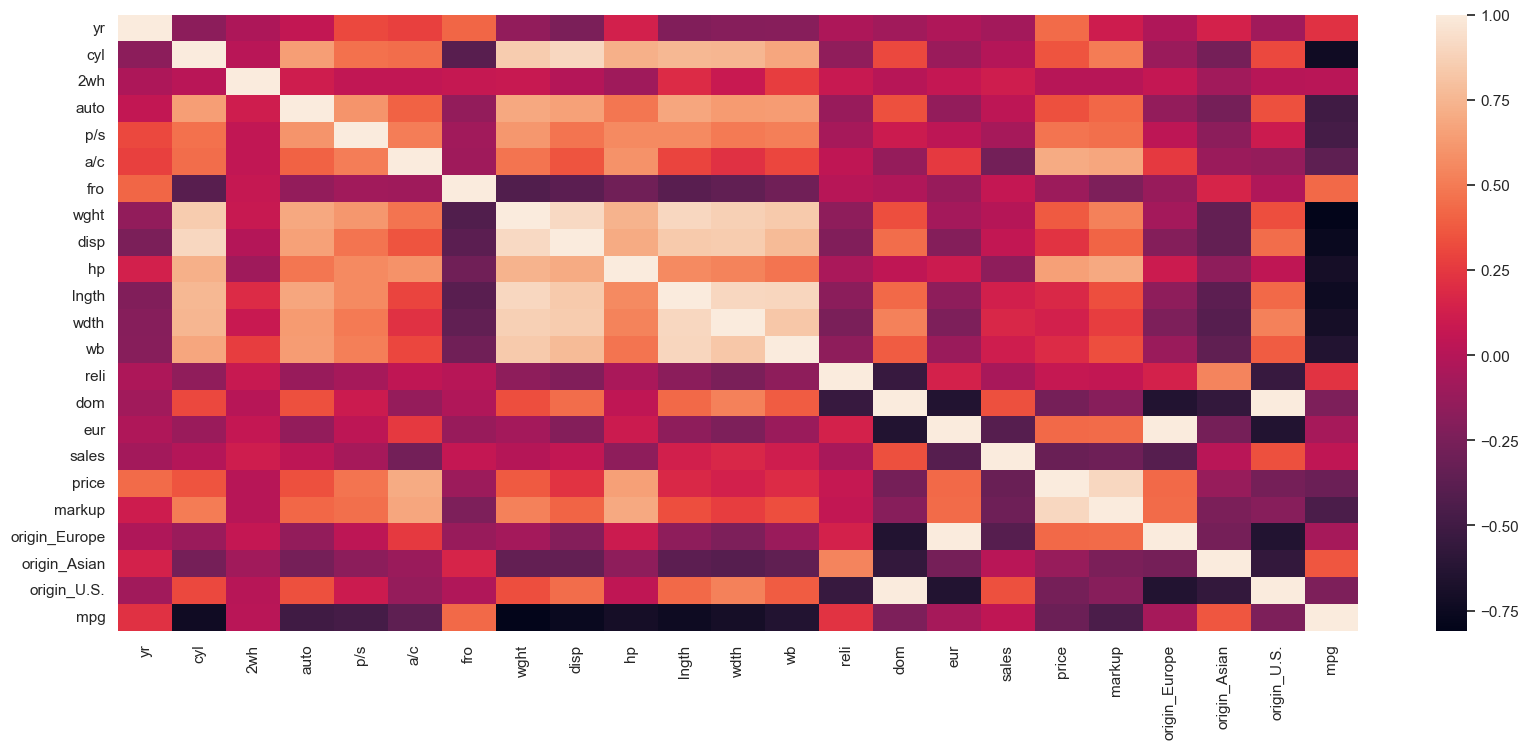

In [17]:
plt.figure(figsize=(20, 8))
heatmap = sns.heatmap(df_training.corr())


## Building a RandomForestRegressor

Using the sklearn package, we are building a model to predict the mpg of a vehicle based on the features from the dataset.

## Splitting the Training Set

Here we split the training set into a training a testing set. This testing set that 
we derive from the training set is used to evaluate the accuracy of our model.
Then we can apply the model to the actual testing set to evaluate the MAPE.

In [21]:
x = df_training.loc[:,df_training.columns !='mpg']
y = df_training["mpg"]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.33, random_state=42)


In [22]:
# Create the model
RF = RandomForestRegressor(n_estimators=100, criterion='absolute_error')

In [23]:
# Fit the model
RF.fit(x_train,y_train)

RandomForestRegressor(criterion='absolute_error')

In [24]:
importance = RF.feature_importances_
list(importance)
plotter = dict(zip(features,importance))
# plt.bar(range(len(plotter)), importance, tick_label=features)
# plt.show()

# feature importances
print(plotter)

{'yr': 0.07250575761813421, 'cyl': 0.36442430427719263, '2wh': 0.005945854493365504, 'auto': 0.0023529850118832233, 'p/s': 0.002142636704449828, 'a/c': 0.0012342011479044431, 'fro': 0.00333241874295518, 'wght': 0.1329733497752035, 'disp': 0.12302235667699153, 'hp': 0.05650431383667336, 'lngth': 0.024234483362223502, 'wdth': 0.02169609821256946, 'wb': 0.025966953196377835, 'reli': 0.015099867710675615, 'dom': 0.002226672780652938, 'eur': 0.004019065247268748, 'sales': 0.049319178884682076, 'price': 0.03912821844036091, 'markup': 0.04520702391084083, 'origin_Europe': 0.004262043458093692, 'origin_Asian': 0.0027688520527308367, 'origin_U.S.': 0.0016333644587703182}


In [25]:
# Make predicitons
y_prediction=RF.predict(x_test)

## To Evaluate the Model

Prior to running the model on the actual testing set, let's evaluate the 
accuracy of the model using MAPE as the metric. First, we will zip the y_test and the y_prediction into a 2-D array.

In [26]:
ys = np.dstack((y_test,y_prediction))

In [27]:
def mape(y_train, y_prediction):
    mape = np.mean(np.abs((y_test - y_prediction)/y_test)) * 100
    return mape

In [28]:
mape(y_train, y_prediction)

6.1055688067720935

Depending on the exact split the MAPE is between 6-6.1%, calculated using the `def mape()` function above.

Perhaps there is a model that minimizes this error further.

## Tuning the Model

The goal here is to see if I can reduce the MAPE by tuning the model, by using only statistically significant features.

## Applying the model to the actual testing set

In [32]:
x = df_training.loc[:,df_training.columns !='mpg'].values
test = df_testing.loc[:, df_testing.columns != 'mpg'].values
y = target.values

In [33]:
predictions = RF.predict(test)

C:\Users\Matthew\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [34]:
np.savetxt("predictions_RF3.csv", 
           predictions,
           delimiter =", ", 
           fmt ='% s')

In [35]:
predictions_df = pd.DataFrame(predictions)
predictions_df.describe()

,0
count,300.000000
mean,21.976100
std,5.480708
min,11.550000
25%,18.027500
50%,21.340000
75%,24.977500
max,43.690000


The results of these predictions are saved in the file predictions_RF3.csv. 